# Пример распознавания автомобильных номеров

https://hackernoon.com/latest-deep-learning-ocr-with-keras-and-supervisely-in-15-minutes-34aecd630ed8

In [1]:
import os
from os.path import join
import json
import random
import itertools
import re
import cv2
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Reshape, Lambda
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing import image

/home/truename/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/truename/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/truename/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/truename/anaconda3/lib/python3.7/site-packages/tensorflow/python/frame

In [2]:
sess = tf.Session()
K.set_session(sess)

## Загружаем алфавит

In [3]:
from collections import Counter
def get_counter(dirpath):
    dirname = os.path.basename(dirpath)
    ann_dirpath = join(dirpath, 'ann')
    letters = ''
    lens = []
    for filename in os.listdir(ann_dirpath):
        json_filepath = join(ann_dirpath, filename)
        description = json.load(open(json_filepath, 'r'))['description']
        lens.append(len(description))
        letters += description
    print('Max plate length in "%s":' % dirname, max(Counter(lens).keys()))
    return Counter(letters)
c_train = get_counter('./data/anpr/train')
letters_train = set(c_train.keys())
letters = sorted(list(letters_train))
print('Letters:', ' '.join(letters))

Max plate length in "train": 8
Letters: 0 1 2 3 4 5 6 7 8 9 A B C E H K M O P T X Y


## Утилиты подготовки входных данных

In [4]:
def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

class TextImageGenerator:
    
    def __init__(self, 
                 dirpath, 
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=8):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        
        img_dirpath = join(dirpath, 'img')
        ann_dirpath = join(dirpath, 'ann')
        self.samples = []
        for filename in os.listdir(img_dirpath):
            name, ext = os.path.splitext(filename)
            if ext == '.png':
                img_filepath = join(img_dirpath, filename)
                json_filepath = join(ann_dirpath, name + '.json')
                description = json.load(open(json_filepath, 'r'))['description']
                if is_valid_str(description):
                    self.samples.append([img_filepath, description])
        
        self.n = len(self.samples)
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = cv2.imread(img_filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img /= 255
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            self.imgs[i, :, :] = img
            self.texts.append(text)
        
    def get_output_size(self):
        return len(letters) + 1
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X_data = np.ones([self.batch_size, 1, self.img_w, self.img_h])
            else:
                X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1))  \
                             * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i] = text_to_labels(text)
                source_str.append(text)
                label_length[i] = len(text)
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [5]:
data_train = TextImageGenerator('./data/anpr/train', 128, 64, 8, 4)
data_train.build_data()

Text generator output (data which will be fed into the neutral network):
1) the_input (image) 128x64


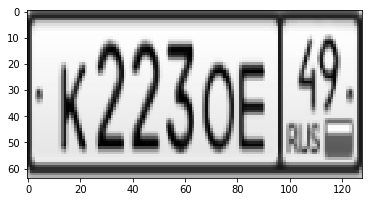

2) the_labels (plate number): K223OE49 is encoded as [15, 2, 2, 3, 17, 13, 4, 9]
3) input_length (width of image that is fed to the loss function): 30 == 128 / 4 - 2
4) label_length (length of plate number): 8


In [6]:
for inp, out in data_train.next_batch():
    print('Text generator output (data which will be fed into the neutral network):')
    if K.image_data_format() == 'channels_first':
        img = inp['the_input'][0, 0, :, :]
    else:
        img = inp['the_input'][0, :, :, 0]
    
    print('1) the_input (image) %dx%d' % img.shape)
    
    plt.imshow(img.T, cmap='gray')
    plt.show()
    print('2) the_labels (plate number): %s is encoded as %s' % 
          (labels_to_text(inp['the_labels'][0]), list(map(int, inp['the_labels'][0]))))
    print('3) input_length (width of image that is fed to the loss function): %d == %d / 4 - 2' % 
          (inp['input_length'][0], data_train.img_w))
    print('4) label_length (length of plate number): %d' % inp['label_length'][0])
    break

## Архитектура сети и функция потерь

In [7]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, 
                            input_length, label_length)

def create_model(img_w, img_h=64, pool_size=2):

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = pool_size
    time_dense_size = 32
    rnn_size = 512

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2),
                        (img_h // (pool_size ** 2)) * conv_filters)
    
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirecitonal GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True,
                kernel_initializer='he_normal', name='gru1')(inner)
    
    gru_1b = GRU(rnn_size, return_sequences=True, 
                 go_backwards=True,
                 kernel_initializer='he_normal', name='gru1_b')(inner)
    
    gru1_merged = add([gru_1, gru_1b])
    
    gru_2 = GRU(rnn_size, return_sequences=True, 
                kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, 
                 go_backwards=True, 
                 kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
    
    # transforms RNN output to character activations:
    inner = Dense(data_train.get_output_size(),
                  kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    
    y_pred = Activation('softmax', name='softmax')(inner)
    
    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[data_train.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [y_pred, labels, input_length, label_length])

    return Model(inputs=[input_data, labels, input_length, label_length],
                 outputs=loss_out)

## Обучение модели

In [8]:
batch_size = 32
pool_size = 2
img_w = 128
img_h = 64 
epochs = 10
downsample_factor = pool_size ** 2
data_train = TextImageGenerator('./data/anpr/train',
                                img_w, img_h,
                                batch_size, downsample_factor)
data_train.build_data()

model = create_model(img_w=img_w, pool_size=pool_size)

optimizer = Adam(lr=3e-4)

# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
_____________________________________

In [9]:
model.fit_generator(generator=data_train.next_batch(),
                    steps_per_epoch=data_train.n,
                    epochs=epochs)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
90/90 [==============================] - 257s 3s/step - loss: 25.1662
Epoch 2/10
90/90 [==============================] - 407s 5s/step - loss: 7.1928
Epoch 3/10
90/90 [==============================] - 433s 5s/step - loss: 0.4674
Epoch 4/10
90/90 [==============================] - 452s 5s/step - loss: 0.1232
Epoch 5/10
90/90 [==============================] - 453s 5s/step - loss: 0.0634
Epoch 6/10
90/90 [==============================] - 438s 5s/step - loss: 0.0396
Epoch 7/10
90/90 [==============================] - 457s 5s/step - loss: 0.0275
Epoch 8/10
90/90 [==============================] - 441s 5s/step - loss: 0.0204
Epoch 9/10
90/90 [==============================] - 433s 5s/step - loss: 0.0158
Epoch 10/10
90/90 [==============================] - 444s 5s/step - loss: 0.0127


## Загружаем обученную ранее модель

In [10]:
model.load_weights('plate-ocr.hd5')

## Декодирование результата

In [11]:
# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.

def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

# Визуализация результата

Predicted: Y853XT1
True: Y853XT81


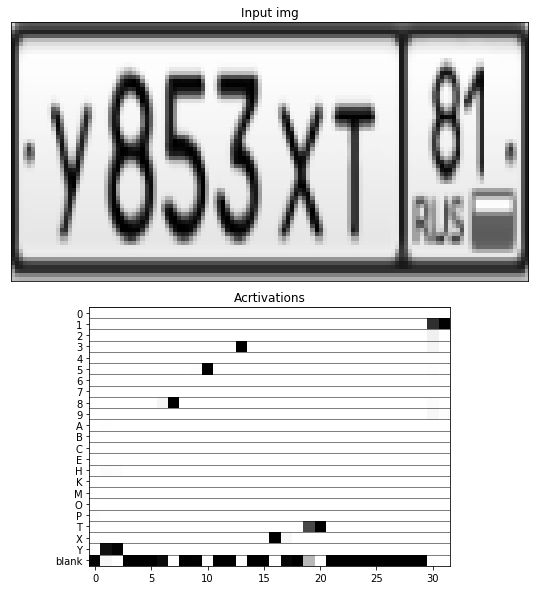

Predicted: A182EX78
True: A182EX78


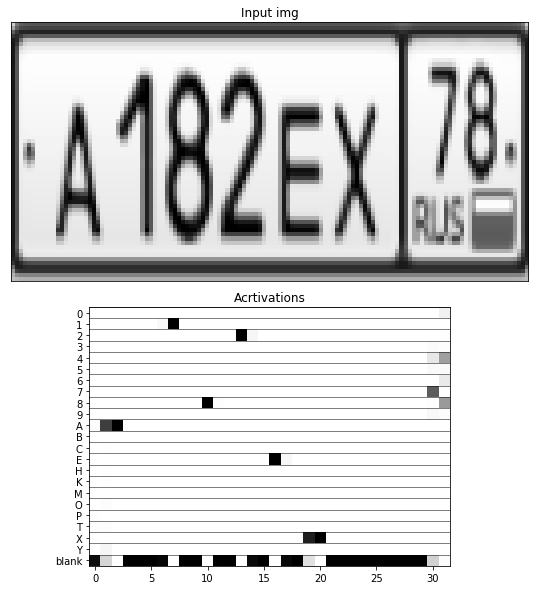

Predicted: X082PT89
True: X082PT69


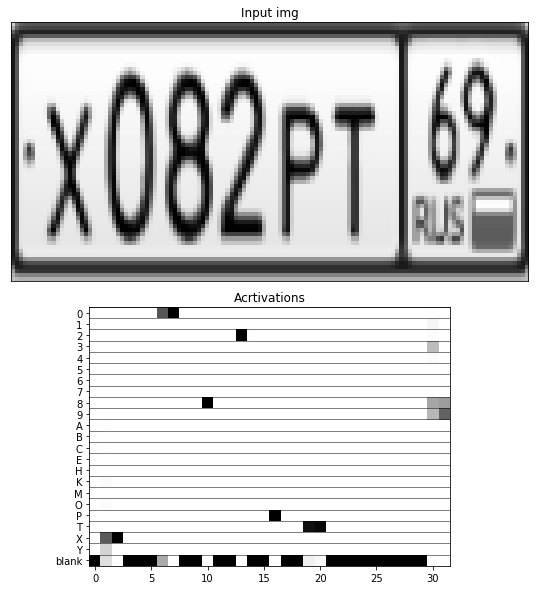

Predicted: X672EC01
True: X672EC01


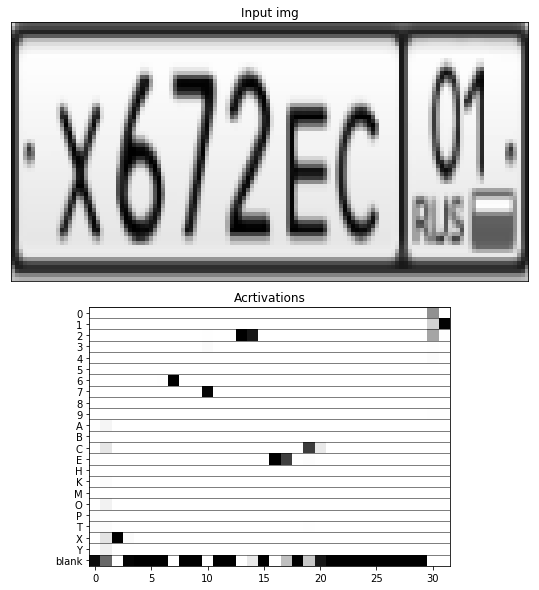

Predicted: X448BC17
True: X448BC17


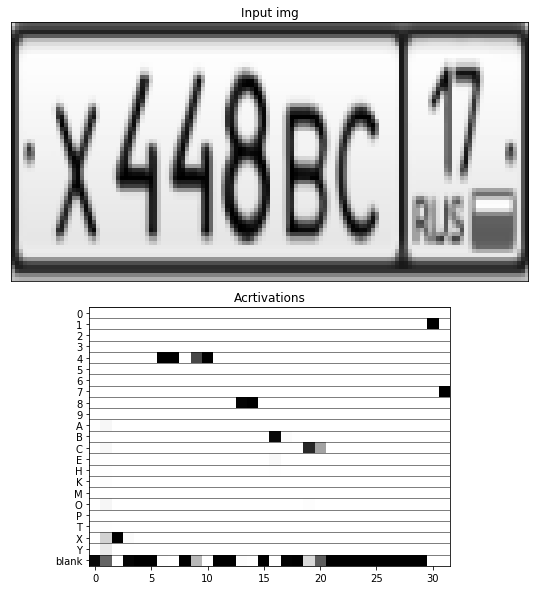

Predicted: C736YH9
True: C736YH59


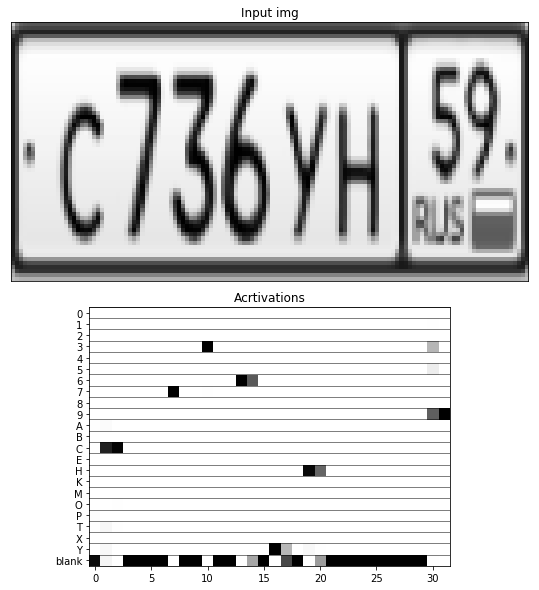

Predicted: O511OT21
True: O511OT51


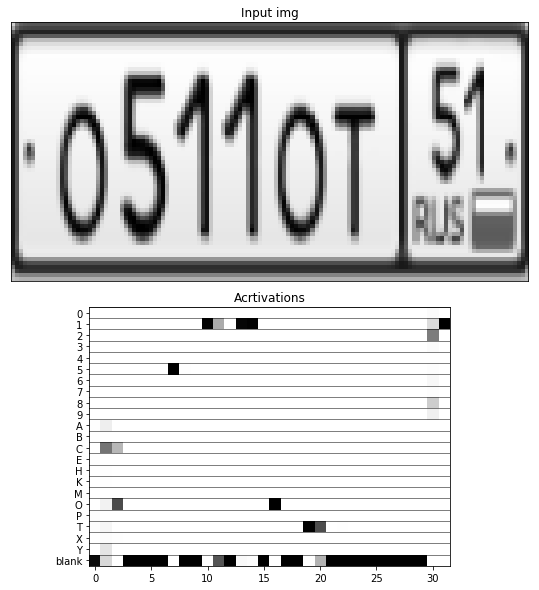

Predicted: B032BM01
True: B032BM01


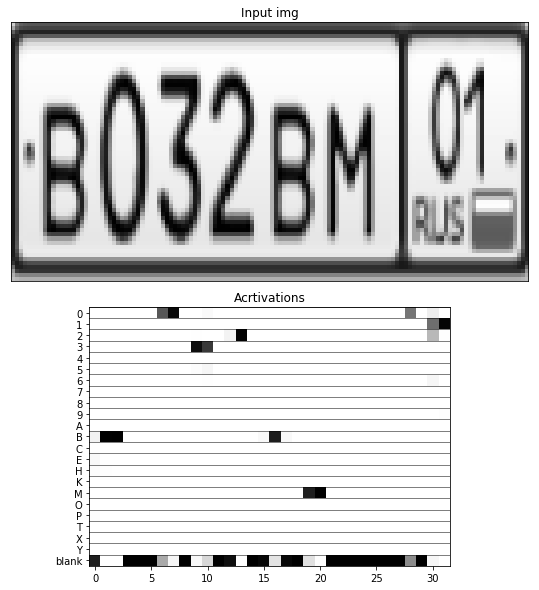

In [12]:
data_test = TextImageGenerator('./data/anpr/test', 128, 64, 8, 4)
data_test.build_data()

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

for inp_value, _ in data_test.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        texts.append(text)
    
    for i in range(bs):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nTrue: %s' % (pred_texts[i], texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Acrtivations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(letters) + 1)))
        ax2.set_yticklabels(letters + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        plt.show()
    break